# **Time Series Forecasting of US Retail Sales (Python Version)**

This notebook demonstrates a time series forecasting workflow, mirroring the steps described in the lecture notes for R but implemented in Python. We use:

- **Inflation-adjusted** and **days-standardized** retail sales data from FRED (monthly, 1992–2017).  
- **Seasonal Naive**, **Exponential Smoothing (ETS)**, and **ARIMA** methods.  
- **Model selection** based on residual diagnostics.



## Types of Time Series Data

![](https://miro.medium.com/max/1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

reference: https://engineering.99x.io/time-series-forecasting-in-machine-learning-3972f7a7a467


## I. Introduction to Time Series Forecasting
- **Goal**: Predict future values of a time-ordered sequence (retail sales).
- **Example Application**: US retail sales (FRED data) from 1992 to December 2017.
- **Business Context**: Forecasting helps in planning and decision-making.

**Data Source:**
- Monthly total retail sales in the US from 1992 through December 2017.
    - https://fred.stlouisfed.org/series/RSXFSN
- CPI data is used to adjust for inflation.
    - https://fred.stlouisfed.org/series/CPIAUCSL



## II. Setting Up the Python Environment

In Python, we rely on:
- **pandas** for data manipulation
- **matplotlib** for visualization
- **statsmodels** for forecasting methods (e.g., Exponential Smoothing)
- **pmdarima** for `auto_arima` (if you want an automated ARIMA approach)

All libraries have been imported at the top of this notebook. 
Make sure you have them installed:

```bash
pip install pandas numpy matplotlib statsmodels
```



## III. Data Preparation and Pre-processing

Steps:
1. **Download** data from FRED (already done).
2. **Adjust for inflation** (convert nominal to constant 2017 dollars using CPI).
3. **Adjust for varying days in each month** (convert monthly sales to sales per day).

We'll assume the CSV has columns:
- `observation_date` (e.g., "1/1/92", "2/1/92", etc.)
- `RSXFSN` (nominal retail sales)
- `CPIAUCSL` (Consumer Price Index)

We'll then create:
- `Real_Sales`: inflation-adjusted sales
- `Sales_per_Day`: daily sales after adjusting for month length

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load the data
# Adjust the file path to your local system as needed
data = pd.read_csv(
    'RSXFSN.csv',
    parse_dates=['observation_date'],
    date_format='%m/%d/%y'  # Specify date format directly
)

# Ensure data is sorted by date
data.sort_values('observation_date', inplace=True)

print("First few rows of the raw data:\n", data.head(), "\n")

First few rows of the raw data:
   observation_date  RSXFSN  CPIAUCSL
0       1992-01-01  130683     138.3
1       1992-02-01  131244     138.6
2       1992-03-01  142488     139.1
3       1992-04-01  147175     139.4
4       1992-05-01  152420     139.7 



In [2]:
# 2) Identify the base CPI for 2024 (last CPI in 2024)
data_2024 = data[(data['observation_date'] >= '2024-01-01') & (data['observation_date'] < '2025-01-01')]
if not data_2024.empty:
    baseCPI = data_2024['CPIAUCSL'].iloc[-1]
    print("Base CPI for 2024:", baseCPI)
else:
    raise ValueError("No data found for 2017 to set a base CPI.")

Base CPI for 2024: 317.603


In [3]:
# 3) Inflation-adjusted sales
data['Real_Sales'] = data['RSXFSN'] * (baseCPI / data['CPIAUCSL'])

In [4]:
# 4) Adjust for number of days in the month
data['Days_in_Month'] = data['observation_date'].dt.days_in_month
data['Sales_per_Day'] = data['Real_Sales'] / data['Days_in_Month']

print("First few rows with inflation and day adjustments:\n",
      data[['observation_date','RSXFSN','CPIAUCSL','Real_Sales','Days_in_Month','Sales_per_Day']].head(10))

First few rows with inflation and day adjustments:
   observation_date  RSXFSN  CPIAUCSL     Real_Sales  Days_in_Month  \
0       1992-01-01  130683     138.3  300110.721974             31   
1       1992-02-01  131244     138.6  300746.667619             29   
2       1992-03-01  142488     139.1  325338.722243             31   
3       1992-04-01  147175     139.4  335317.227582             30   
4       1992-05-01  152420     139.7  346521.469291             31   
5       1992-06-01  151849     140.1  344237.672712             30   
6       1992-07-01  152586     140.5  344923.639559             31   
7       1992-08-01  152476     140.8  343940.589687             31   
8       1992-09-01  148158     141.1  333489.902721             30   
9       1992-10-01  155987     141.7  349625.541009             31   

   Sales_per_Day  
0    9680.991031  
1   10370.574745  
2   10494.797492  
3   11177.240919  
4   11178.111913  
5   11474.589090  
6   11126.569018  
7   11094.857732  
8   11

## IV. Initial Data Handling

We'll store the **sales per day** series as our main time series. 
- Index the data by `observation_date`.
- Convert to a monthly frequency (`asfreq('MS')`) to ensure regular monthly spacing.


In [5]:
# Set the date as the index
df = data.set_index('observation_date').sort_index()

# Create a monthly series for Sales_per_Day
ts_data = df['Sales_per_Day'].asfreq('MS')  # 'MS' = Month Start
print("Time series start:", ts_data.index[0])
print("Time series end:", ts_data.index[-1])
print("Frequency:", ts_data.index.freq)

Time series start: 1992-01-01 00:00:00
Time series end: 2025-02-01 00:00:00
Frequency: <MonthBegin>


In [6]:
# Drop any missing data
ts_data.dropna(inplace=True)

# Quick look
ts_data.head(12)

observation_date
1992-01-01     9680.991031
1992-02-01    10370.574745
1992-03-01    10494.797492
1992-04-01    11177.240919
1992-05-01    11178.111913
1992-06-01    11474.589090
1992-07-01    11126.569018
1992-08-01    11094.857732
1992-09-01    11116.330091
1992-10-01    11278.243258
1992-11-01    11534.733022
1992-12-01    13776.524209
Freq: MS, Name: Sales_per_Day, dtype: float64

## V. Declaring Time Series Data

In R, we typically use `ts()` with `start=c(1992,1), frequency=12`. 
In Python, a **DatetimeIndex** with monthly frequency effectively accomplishes the same. 
This indexing allows us to apply time-series functions from `statsmodels`.

In [7]:
# Already declared as ts_data with monthly freq. Let's just verify.
print(ts_data)

observation_date
1992-01-01     9680.991031
1992-02-01    10370.574745
1992-03-01    10494.797492
1992-04-01    11177.240919
1992-05-01    11178.111913
                  ...     
2024-10-01    20551.715478
2024-11-01    21476.333548
2024-12-01    22704.258065
2025-01-01    18496.247425
2025-02-01    19574.847262
Freq: MS, Name: Sales_per_Day, Length: 398, dtype: float64


## VI. Preliminary Time Series Analysis

1. **Time Plot**: Check for trends, seasonality, major events (like the 2008 recession).
2. **Differencing**: Potentially remove trend to see if the series becomes stationary.
3. **Seasonality**: Investigate with seasonal plots or subseries plots. 
   In Python, we can use `statsmodels.tsa.seasonal_decompose` or custom plots.

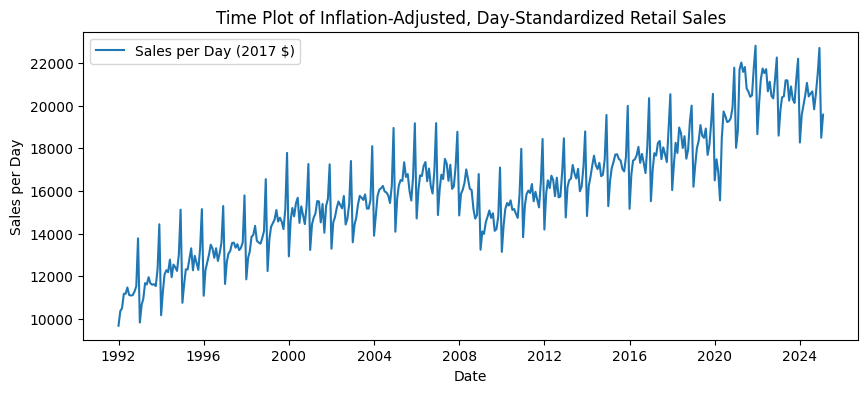

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(ts_data, label='Sales per Day (2017 $)')
plt.title("Time Plot of Inflation-Adjusted, Day-Standardized Retail Sales")
plt.xlabel("Date")
plt.ylabel("Sales per Day")
plt.legend()
plt.show()

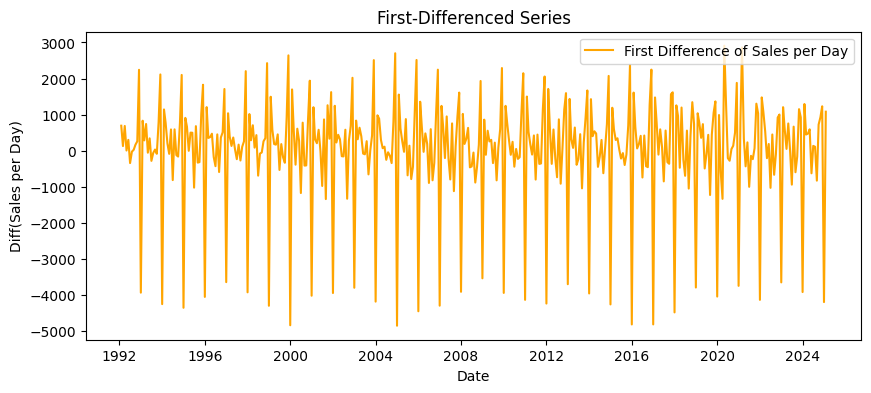

In [9]:
# Let's do a quick differencing to see if that removes trend
ts_data_diff = ts_data.diff().dropna()

plt.figure(figsize=(10, 4))
plt.plot(ts_data_diff, color='orange', label='First Difference of Sales per Day')
plt.title("First-Differenced Series")
plt.xlabel("Date")
plt.ylabel("Diff(Sales per Day)")
plt.legend()
plt.show()

Series appers trend-stationary, use to investigate sesonality.

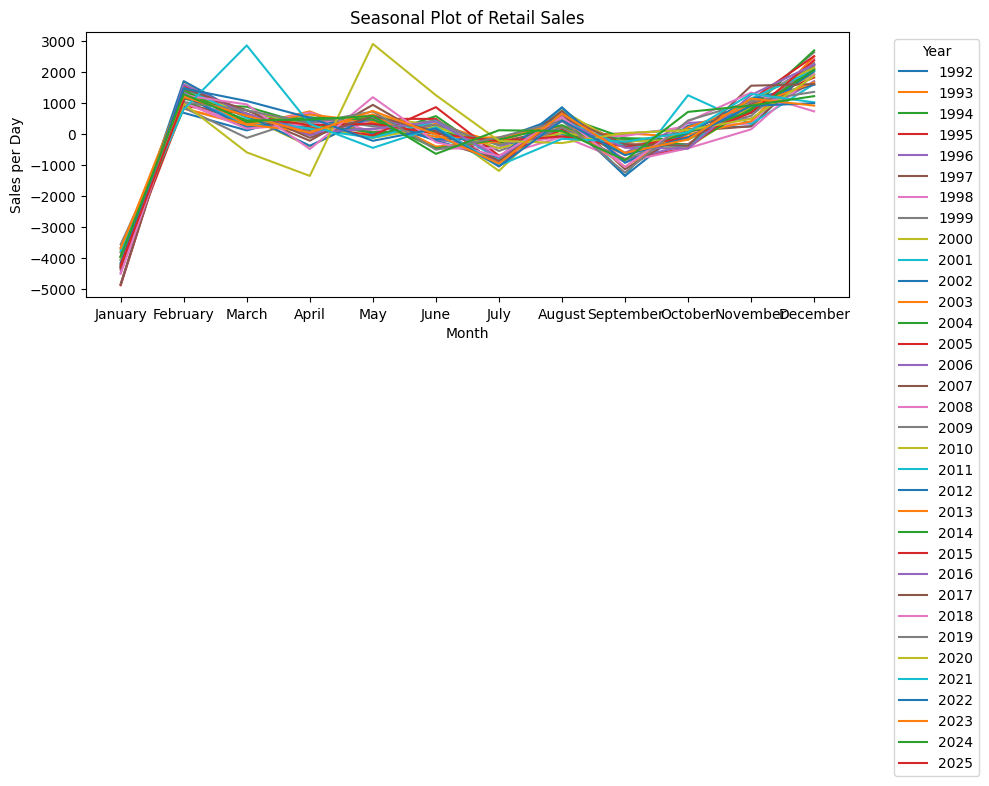

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import seaborn as sns


# Suppose you already have a time series like this:
# Convert to DataFrame for easy manipulation
df = ts_data_diff.to_frame(name='value')

# Extract 'year' and 'month' from the DateTimeIndex
df['month'] = df.index.month
df['year'] = df.index.year
df['month_name'] = df.index.month_name()


# Pivot so that:
#   rows = month (1..12)
#   columns = year
#   values = your time series
pivoted = df.pivot(index='month', columns='year', values='value')

# Optional: Replace numeric month (1..12) with month names
pivoted.index = [calendar.month_name[m] for m in pivoted.index]

plt.figure(figsize=(10, 6))

for year in pivoted.columns:
    plt.plot(pivoted.index, pivoted[year], label=year)

plt.title("Seasonal Plot of Retail Sales")
plt.xlabel("Month")
plt.ylabel("Sales per Day")
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')  # place legend outside
plt.tight_layout()
plt.show()



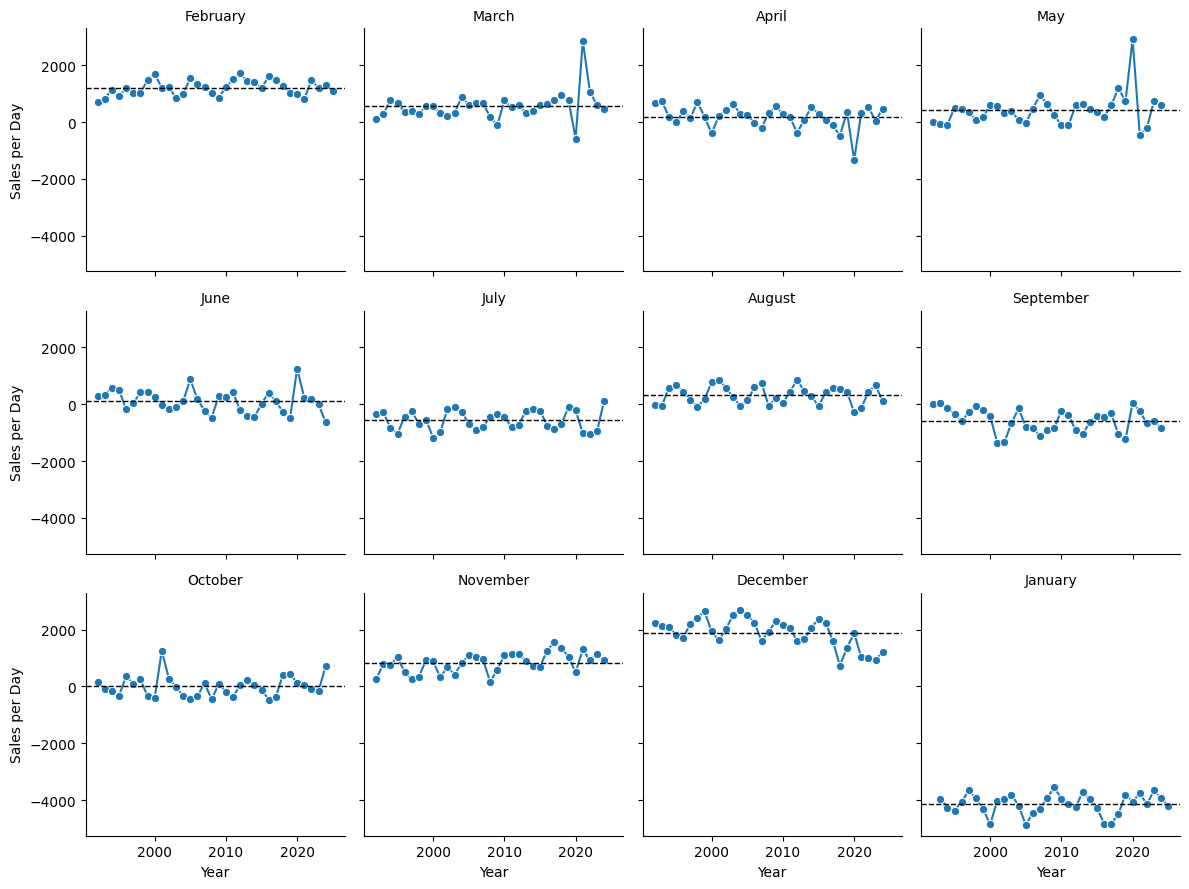

In [11]:
# 1. Create FacetGrid
g = sns.FacetGrid(df, col='month_name', col_wrap=4, sharey=True, height=3)

# 2. Plot lines across years for each month
g.map_dataframe(sns.lineplot, x='year', y='value', marker='o')

# 3. Add horizontal mean line
def plot_monthly_mean(data, **kwargs):
    plt.axhline(y=data['value'].mean(), color='black', linestyle='--', linewidth=1)

g.map_dataframe(plot_monthly_mean)

# 4. Labeling and layout
g.set_axis_labels("Year", "Sales per Day")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()


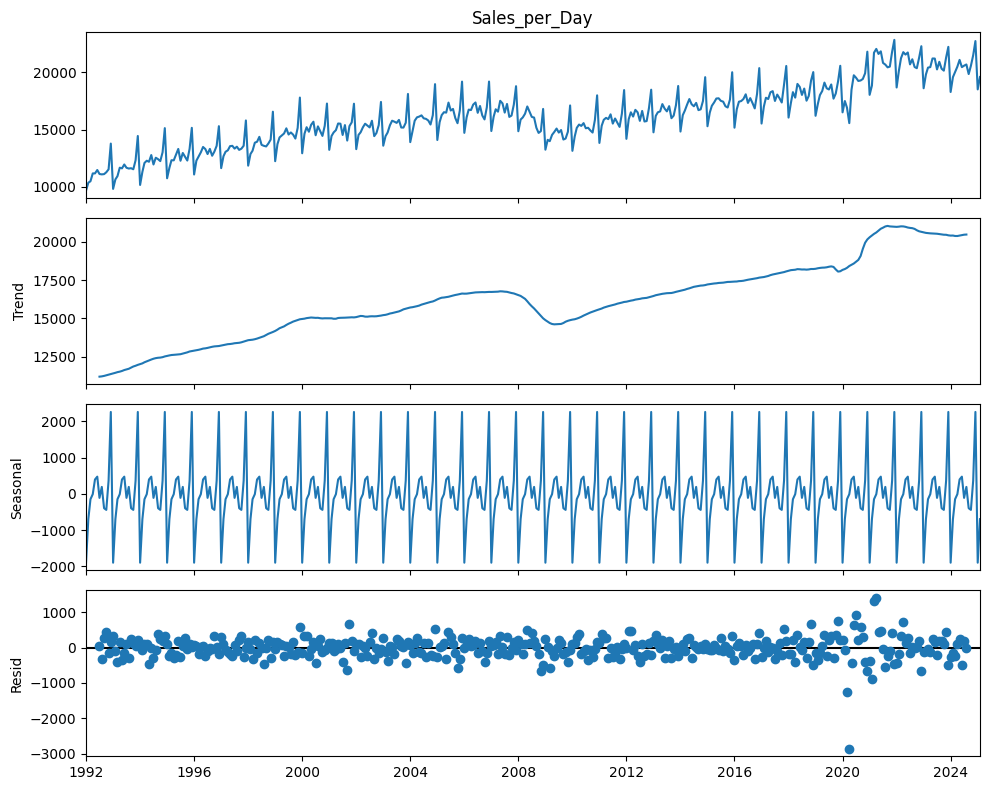

In [12]:
# Seasonal decomposition (additive) to visually check trend & seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts_data, model='additive', period=12)
fig = result.plot()
fig.set_size_inches(10, 8)
plt.tight_layout()
plt.show()

Observations: 
- Trend is upward.
- Clear seasonality (sales peak near end of each year).
- To remove the trend, we took the First Difference.
- The First Difference series still has seasonality.

## VII. Forecasting Methods

We compare three approaches:
1. **Seasonal Naive** (benchmark)
2. **Exponential Smoothing (ETS)**
3. **ARIMA** (using `auto_arima` from `pmdarima` or manual ARIMA from `statsmodels`)


### 1. Seasonal Naive Benchmark

- In R, `snaive()` sets next January = last January, next February = last February, etc.
- In Python, we can implement a simple function that shifts the data by 12 months for the forecast.
- y_t = y_{t-s} + e_t


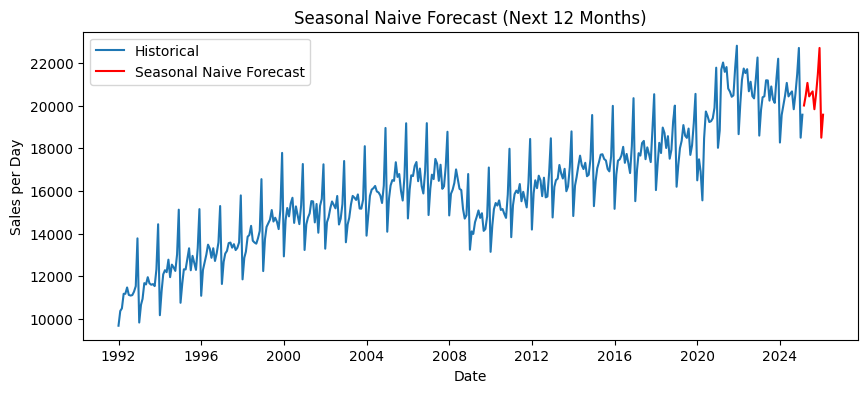

Seasonal Naive Residuals (last 12 months) mean: -18.106237403146526


In [13]:
def seasonal_naive_forecast(series, steps=12):
    """
    Forecast 'steps' periods ahead using seasonal naive approach:
    Forecast for month t+12 = Actual value at month t.
    """
    last_year = series[-12:].values  # the last 12 months
    # Repeat them to get 'steps' months of forecast
    repeats = (steps // 12) + 1
    forecast_vals = np.tile(last_year, repeats)[:steps]
    return forecast_vals

# We'll do an in-sample "fit" to get residuals:
# Let's compare the last 12 months to the 12 months prior for "fitted values"
# (Simple approach for demonstration—more advanced residual checks might require a train/test split.)

# We'll forecast the next 12 months (for demonstration).
forecast_horizon = 12
snaive_forecast = seasonal_naive_forecast(ts_data, steps=forecast_horizon)

# Make a forecast index that starts after the last date in ts_data
forecast_start = ts_data.index[-1] + pd.offsets.MonthBegin()
forecast_index = pd.date_range(start=forecast_start, periods=forecast_horizon, freq='MS')

snaive_series = pd.Series(snaive_forecast, index=forecast_index, name='SNaive_Forecast')

# Plot
plt.figure(figsize=(10, 4))
plt.plot(ts_data, label='Historical')
plt.plot(snaive_series, label='Seasonal Naive Forecast', color='red')
plt.title("Seasonal Naive Forecast (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Sales per Day")
plt.legend()
plt.show()

# We can do a quick residual check on the last 12 months of the historical series
# vs the 12 months prior. This is rudimentary, just to illustrate the concept.
historical_last_12 = ts_data[-12:]
naive_fit_12 = ts_data.shift(12).dropna()[-12:]  # the "fitted" values
residuals_snaive = historical_last_12 - naive_fit_12

print("Seasonal Naive Residuals (last 12 months) mean:", residuals_snaive.mean())

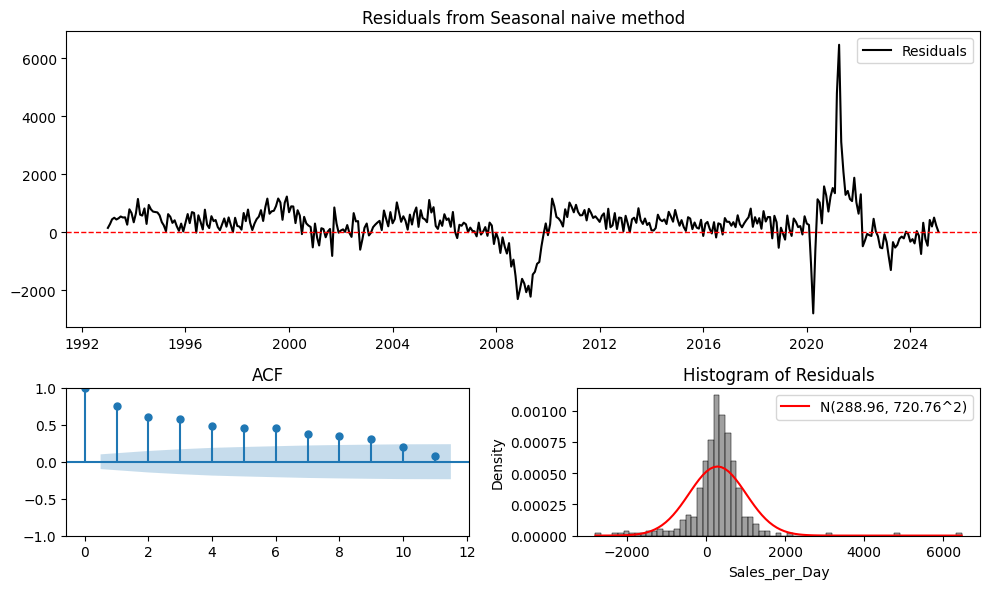

In [14]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import scipy.stats as stats

def check_residuals_snaive(residuals, method_name="Seasonal naive"):
    """
    Replicate R's checkresiduals style plots for given residuals.
    Creates:
      1) Time-series plot of residuals
      2) ACF plot
      3) Histogram with normal overlay
    
    Parameters
    ----------
    residuals : pandas Series or array-like
        Residual values from a forecast model.
    method_name : str
        Name of the method (used in the plot title).
    """
    # Convert to Series if not already
    if not isinstance(residuals, pd.Series):
        residuals = pd.Series(residuals)
    
    # Create a 2x2 grid: top row for residual time series,
    # bottom row for ACF and histogram
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])
    
    # Subplot 1: Residual time series
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(residuals, label='Residuals', color='black')
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax1.set_title(f'Residuals from {method_name} method')
    ax1.legend()
    
    # Subplot 2: ACF of residuals
    ax2 = fig.add_subplot(gs[1, 0])
    plot_acf(residuals.dropna(), ax=ax2, lags=11)
    ax2.set_title('ACF')
    
    # Subplot 3: Histogram with normal overlay
    ax3 = fig.add_subplot(gs[1, 1])
    # Use a density-based histogram so we can directly overlay a PDF
    sns.histplot(residuals, ax=ax3, color='gray', kde=False, stat='density')
    
    # Fit a normal distribution
    mu, sigma = stats.norm.fit(residuals.dropna())
    x = np.linspace(residuals.min(), residuals.max(), 100)
    pdf = stats.norm.pdf(x, mu, sigma)
    ax3.plot(x, pdf, 'r-', label=f'N({mu:.2f}, {sigma:.2f}^2)')
    ax3.set_title('Histogram of Residuals')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# If we have monthly data from 1992 to 2017,
# for each month from 1993 onward, seasonal naive is just last year's same month.
# We'll align those in-sample fitted values with actual data and compute residuals.

# SHIFT by 12 months:
snaive_in_sample = ts_data.shift(12)  # This aligns each month with the same month last year

# Residuals for entire time series (except the first 12 months which don't have a prior year)
residuals_snaive_all = ts_data[12:] - snaive_in_sample[12:]

# Then you can plot the entire time period's residuals:
check_residuals_snaive(residuals_snaive_all)


### 2. Exponential Smoothing (ETS)

Python's `statsmodels` provides an **ExponentialSmoothing** class. 
It can model trend and seasonality directly (additive or multiplicative).

- In R, we'd do: `ets(Y)`.
- Here, we do:

```python
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(...)
fit = model.fit(...)
```

ETS model summary:
                        ExponentialSmoothing Model Results                       
Dep. Variable:            Sales_per_Day   No. Observations:                  398
Model:             ExponentialSmoothing   SSE                       57359149.445
Optimized:                         True   AIC                           4759.600
Trend:                         Additive   BIC                           4823.383
Seasonal:                      Additive   AICC                          4761.404
Seasonal Periods:                    12   Date:                 Mon, 31 Mar 2025
Box-Cox:                          False   Time:                         12:05:07
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4647199                alpha                 True
smoot

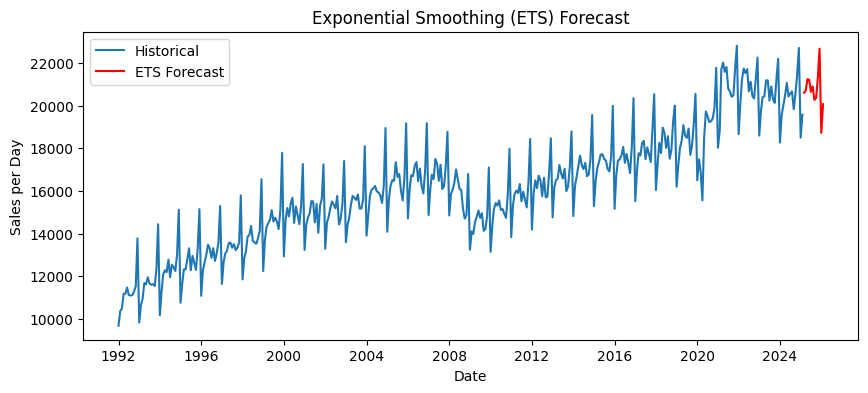

ETS residuals mean: -0.19476059486170477


In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Use the original ts_data instead of the differenced series.
ets_model = ExponentialSmoothing(
    ts_data, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12, 
    initialization_method='estimated'
)

# Increase maxiter if needed (here using 1000 iterations)
ets_fit = ets_model.fit(optimized=True)
print("ETS model summary:\n", ets_fit.summary())

# Forecast the next 12 months
forecast_horizon = 12  # Make sure this variable is defined
ets_forecast = ets_fit.forecast(steps=forecast_horizon)

plt.figure(figsize=(10, 4))
plt.plot(ts_data, label='Historical')
plt.plot(ets_forecast.index, ets_forecast, label='ETS Forecast', color='red')
plt.title("Exponential Smoothing (ETS) Forecast")
plt.xlabel("Date")
plt.ylabel("Sales per Day")
plt.legend()
plt.show()

# Residuals and their mean
ets_residuals = ets_fit.resid
print("ETS residuals mean:", np.mean(ets_residuals))


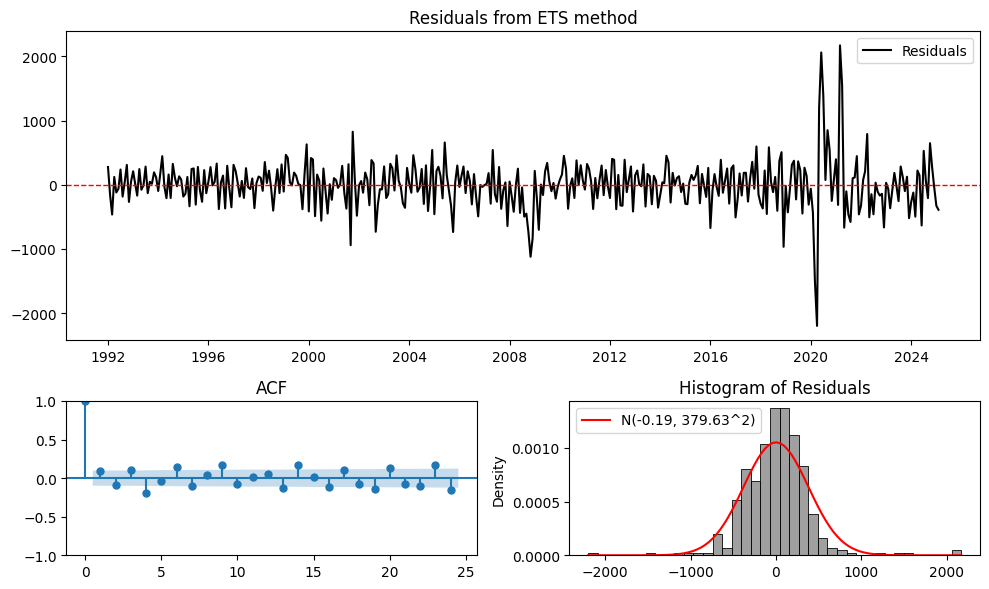

In [16]:
def check_residuals(residuals, method_name="ETS"):
    """
    Replicate R's checkresiduals style plots for given residuals.
    Creates:
      1) Time-series plot of residuals
      2) ACF plot
      3) Histogram with normal overlay
    
    Parameters
    ----------
    residuals : pandas Series or array-like
        Residual values from a forecast model (e.g., ETS).
    method_name : str
        Name of the method (used in the plot title).
    """
    # Convert to Series if not already
    if not isinstance(residuals, pd.Series):
        residuals = pd.Series(residuals)
    
    # Create a 2x2 grid: top row for residual time series,
    # bottom row for ACF and histogram
    fig = plt.figure(figsize=(10, 6))
    gs = fig.add_gridspec(2, 2, height_ratios=[2, 1])
    
    # Subplot 1: Residual time series
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(residuals, label='Residuals', color='black')
    ax1.axhline(y=0, color='red', linestyle='--', linewidth=1)
    ax1.set_title(f'Residuals from {method_name} method')
    ax1.legend()
    
    # Subplot 2: ACF of residuals
    ax2 = fig.add_subplot(gs[1, 0])
    plot_acf(residuals.dropna(), ax=ax2, lags=24)
    ax2.set_title('ACF')
    
    # Subplot 3: Histogram with normal overlay
    ax3 = fig.add_subplot(gs[1, 1])
    # Use a density-based histogram so we can overlay a PDF
    sns.histplot(residuals, ax=ax3, color='gray', kde=False, stat='density')
    
    # Fit a normal distribution to the residuals
    mu, sigma = stats.norm.fit(residuals.dropna())
    x = np.linspace(residuals.min(), residuals.max(), 100)
    pdf = stats.norm.pdf(x, mu, sigma)
    ax3.plot(x, pdf, 'r-', label=f'N({mu:.2f}, {sigma:.2f}^2)')
    ax3.set_title('Histogram of Residuals')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

check_residuals(ets_residuals, method_name="ETS")



### 3. ARIMA Models

- In R, `auto.arima()` automatically selects parameters. 
- It can handle trend/seasonality by differencing internally.
- We fit a seasonal ARIMA model with order parameters (1,1,1) and seasonal_order (1,1,1,12).
- Adjust these parameters as needed based on your data and model diagnostics.

                                     SARIMAX Results                                      
Dep. Variable:                      Sales_per_Day   No. Observations:                  398
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2739.829
Date:                            Mon, 31 Mar 2025   AIC                           5489.657
Time:                                    12:05:08   BIC                           5509.238
Sample:                                01-01-1992   HQIC                          5497.434
                                     - 02-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2089      0.054      3.891      0.000       0.104       0.314
ma.L1         -0.6288      0.045   

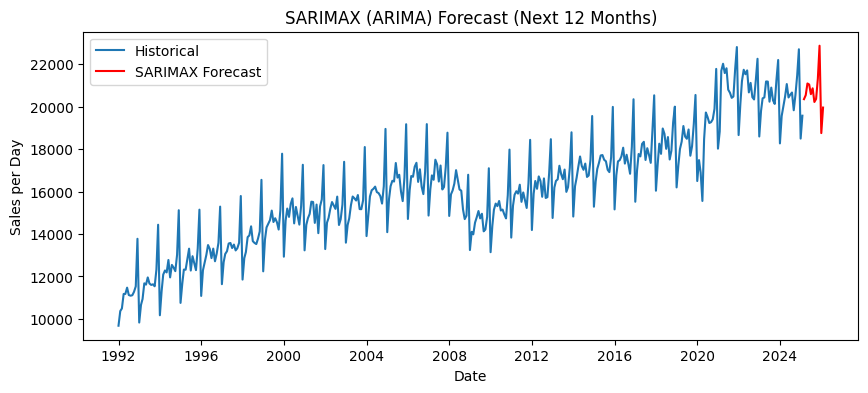

SARIMAX residuals mean: 8.32911174363022


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the ARIMA model using SARIMAX
# Note: Adjust (order, seasonal_order) as needed.
arima_model = SARIMAX(ts_data, 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False, 
                        enforce_invertibility=False)

sarimax_fit = arima_model.fit(disp=False)
print(sarimax_fit.summary())

# Forecast the next 12 months
forecast_horizon = 12
sarimax_forecast = sarimax_fit.get_forecast(steps=forecast_horizon)
sarimax_pred = sarimax_forecast.predicted_mean

# Create forecast index
forecast_index = pd.date_range(ts_data.index[-1] + pd.offsets.MonthBegin(),
                               periods=forecast_horizon, freq='MS')
sarimax_pred.index = forecast_index

# Plot the SARIMAX forecast
plt.figure(figsize=(10, 4))
plt.plot(ts_data, label='Historical')
plt.plot(sarimax_pred, label='SARIMAX Forecast', color='red')
plt.title("SARIMAX (ARIMA) Forecast (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Sales per Day")
plt.legend()
plt.show()

# In-sample predictions and residuals
sarimax_fitted = sarimax_fit.fittedvalues
residuals_sarimax = ts_data - sarimax_fitted
print("SARIMAX residuals mean:", np.mean(residuals_sarimax.dropna()))

SARIMAX model summary:
                                     SARIMAX Results                                      
Dep. Variable:                      Sales_per_Day   No. Observations:                  398
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2739.829
Date:                            Mon, 31 Mar 2025   AIC                           5489.657
Time:                                    12:05:10   BIC                           5509.238
Sample:                                01-01-1992   HQIC                          5497.434
                                     - 02-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2089      0.054      3.891      0.000       0.104       0.314
ma.L1       

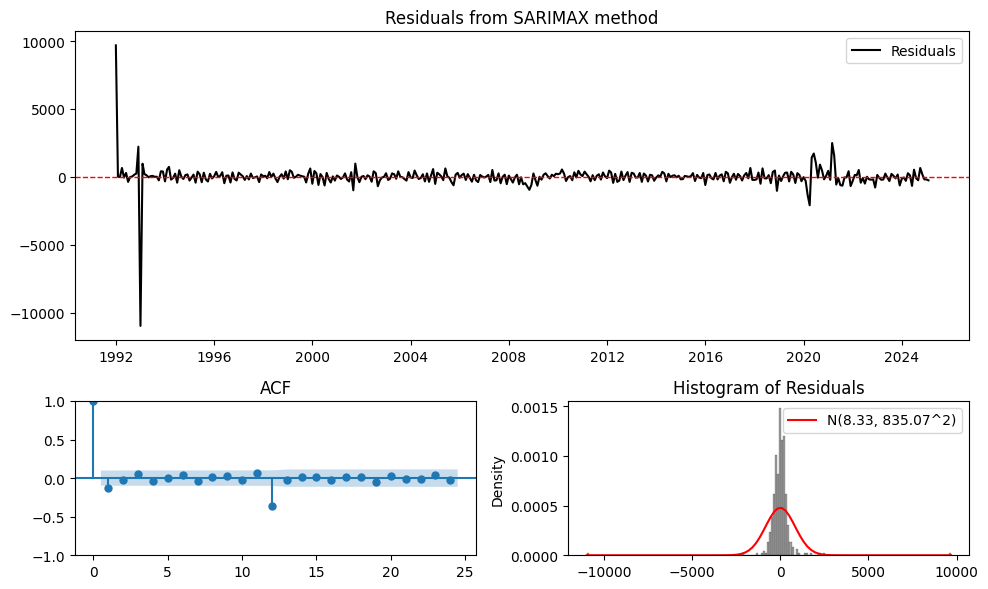

In [18]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMAX model on your time series data (using original ts_data)
sarimax_model = SARIMAX(
    ts_data,
    order=(1, 1, 1), 
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_fit = sarimax_model.fit(disp=False)
print("SARIMAX model summary:")
print(sarimax_fit.summary())

# Extract residuals from the SARIMAX model
sarimax_residuals = sarimax_fit.resid

# Use the check_residuals function to plot diagnostics for SARIMAX residuals
check_residuals(sarimax_residuals, method_name="SARIMAX")


## VIII. Model Selection and Forecasting

- We have three approaches:
  1. **Seasonal Naive**  
  2. **ETS**  
  3. **ARIMA**  
- We can compare them using:
  - **Residual diagnostics** (mean close to 0, minimal autocorrelation).
  - **Standard deviation of residuals** or other error metrics (MAE, RMSE).
- Typically, the model with the lowest forecast error and well-behaved residuals is chosen.

Below is a quick demonstration of computing the RMSE for each model on a "hold-out" set. 
(In a more rigorous setup, we'd do a train/test split. For brevity, we do a simple approach.)

In [19]:
from sklearn.metrics import mean_squared_error

# Let's define a function to compute in-sample RMSE for a quick comparison:
def in_sample_rmse(actual, fitted):
    # Both must be aligned by index
    common_index = actual.index.intersection(fitted.index)
    mse = mean_squared_error(actual.loc[common_index], fitted.loc[common_index])
    return np.sqrt(mse)

# Seasonal Naive in-sample fitted: shift by 12
snaive_fitted = ts_data.shift(12).dropna()
rmse_snaive = in_sample_rmse(ts_data.dropna(), snaive_fitted)
print("Seasonal Naive in-sample RMSE:", rmse_snaive)

# ETS in-sample fitted
ets_in_sample = pd.Series(ets_fit.fittedvalues, index=ts_data.index)
rmse_ets = in_sample_rmse(ts_data, ets_in_sample)
print("ETS in-sample RMSE:", rmse_ets)

# ARIMA in-sample fitted (we already have `sarimax_fitted`)
arima_in_sample = pd.Series(sarimax_fitted, index=ts_data.index)
rmse_arima = in_sample_rmse(ts_data, arima_in_sample)
print("ARIMA in-sample RMSE:", rmse_arima)

# The model with the lowest RMSE (or other error metric) is typically considered "best" in-sample.
# Then we'd use that model to forecast out-of-sample.


Seasonal Naive in-sample RMSE: 776.5237413733693
ETS in-sample RMSE: 379.62937971542755
ARIMA in-sample RMSE: 835.1101734884423


ETS model summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:            Sales_per_Day   No. Observations:                  398
Model:             ExponentialSmoothing   SSE                       57359149.445
Optimized:                         True   AIC                           4759.600
Trend:                         Additive   BIC                           4823.383
Seasonal:                      Additive   AICC                          4761.404
Seasonal Periods:                    12   Date:                 Mon, 31 Mar 2025
Box-Cox:                          False   Time:                         12:05:10
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4647199                alpha                 True
smooth

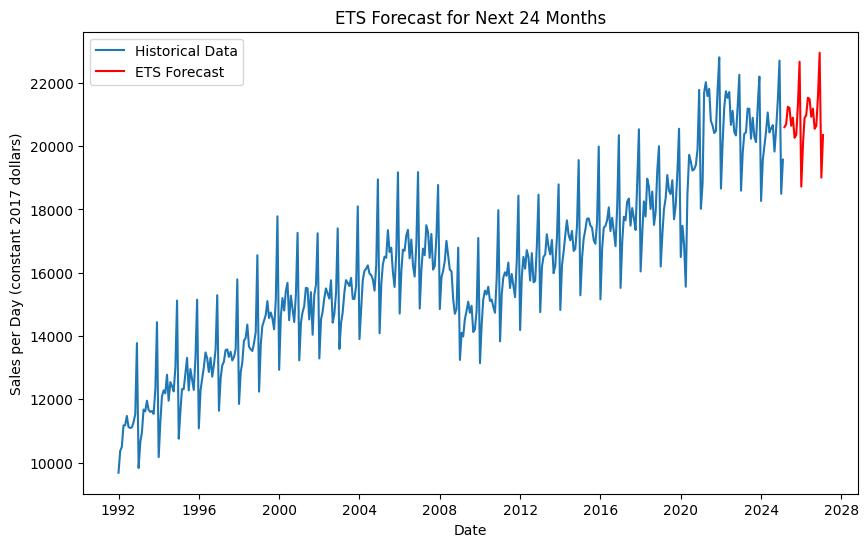

ETS Forecast for the next 24 months:
2025-03-01    20603.496660
2025-04-01    20696.654666
2025-05-01    21246.300181
2025-06-01    21208.040272
2025-07-01    20647.483328
2025-08-01    20901.270096
2025-09-01    20266.501796
2025-10-01    20359.060241
2025-11-01    21305.996637
2025-12-01    22670.120191
2026-01-01    18723.769273
2026-02-01    20067.949790
2026-03-01    20887.346534
2026-04-01    20980.504540
2026-05-01    21530.150055
2026-06-01    21491.890146
2026-07-01    20931.333202
2026-08-01    21185.119970
2026-09-01    20550.351670
2026-10-01    20642.910115
2026-11-01    21589.846511
2026-12-01    22953.970065
2027-01-01    19007.619147
2027-02-01    20351.799664
Freq: MS, dtype: float64


In [20]:
# Forecasting the next 24 months using ETS (Exponential Smoothing)

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Define forecast horizon (24 months)
forecast_horizon = 24

# Fit the ETS model on the original time series (ts_data)
ets_model = ExponentialSmoothing(
    ts_data, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12, 
    initialization_method='estimated'
)

# Fit the model
ets_fit = ets_model.fit(optimized=True)
print("ETS model summary:")
print(ets_fit.summary())

# Forecast the next 24 months
ets_forecast = ets_fit.forecast(steps=forecast_horizon)

# Plot the historical data and forecast
plt.figure(figsize=(10, 6))
plt.plot(ts_data, label='Historical Data')
plt.plot(ets_forecast.index, ets_forecast, label='ETS Forecast', color='red')
plt.title("ETS Forecast for Next 24 Months")
plt.xlabel("Date")
plt.ylabel("Sales per Day (constant 2017 dollars)")
plt.legend()
plt.show()

# Optionally, print forecast values
print("ETS Forecast for the next 24 months:")
print(ets_forecast)


ETS model summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:            Sales_per_Day   No. Observations:                  398
Model:             ExponentialSmoothing   SSE                       57359149.445
Optimized:                         True   AIC                           4759.600
Trend:                         Additive   BIC                           4823.383
Seasonal:                      Additive   AICC                          4761.404
Seasonal Periods:                    12   Date:                 Mon, 31 Mar 2025
Box-Cox:                          False   Time:                         12:05:11
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4647199                alpha                 True
smooth

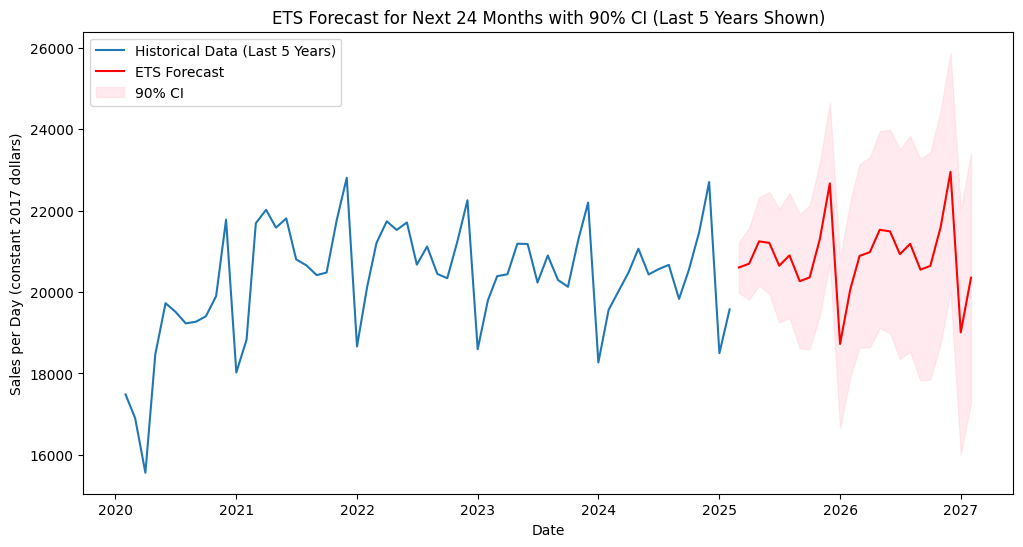

Most recent 5 forecast values:
                Forecast      Lower_90      Upper_90
2026-10-01  20642.910115  17850.104826  23435.715404
2026-11-01  21589.846511  18728.072681  24451.620341
2026-12-01  22953.970065  20024.851166  25883.088963
2027-01-01  19007.619147  16012.669132  22002.569161
2027-02-01  20351.799664  17292.434752  23411.164575


In [21]:
# -----------------------------
# Fit ETS Model on the Original Series (recommended)
# -----------------------------
ets_model = ExponentialSmoothing(
    ts_data, 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12, 
    initialization_method='estimated'
)
ets_fit = ets_model.fit(optimized=True)
print("ETS model summary:")
print(ets_fit.summary())

# -----------------------------
# Forecast the next 24 months
# -----------------------------
forecast_horizon = 24
ets_forecast = ets_fit.forecast(steps=forecast_horizon)

# -----------------------------
# Compute 90% Confidence Intervals
# -----------------------------
# Using the in-sample residual standard deviation as an approximation
sigma = np.std(ets_fit.resid.dropna())
z = 1.645  # Critical value for 90% two-tailed interval

ci_lower = []
ci_upper = []

for h in range(1, forecast_horizon+1):
    se = sigma * np.sqrt(h)  # approximate standard error for h-step forecast
    lower = ets_forecast.iloc[h-1] - z * se
    upper = ets_forecast.iloc[h-1] + z * se
    ci_lower.append(lower)
    ci_upper.append(upper)

ci_lower = pd.Series(ci_lower, index=ets_forecast.index)
ci_upper = pd.Series(ci_upper, index=ets_forecast.index)

# -----------------------------
# Plot the Forecast with 90% Confidence Interval for the last 5 years of history
# -----------------------------
# Extract only the last 5 years of historical data
start_date = ts_data.index[-1] - pd.DateOffset(years=5)
recent_ts = ts_data[ts_data.index >= start_date]

plt.figure(figsize=(12,6))
plt.plot(recent_ts, label='Historical Data (Last 5 Years)')
plt.plot(ets_forecast, label='ETS Forecast', color='red')
plt.fill_between(ets_forecast.index, ci_lower, ci_upper, color='pink', alpha=0.3, label='90% CI')
plt.title("ETS Forecast for Next 24 Months with 90% CI (Last 5 Years Shown)")
plt.xlabel("Date")
plt.ylabel("Sales per Day (constant 2017 dollars)")
plt.legend()
plt.show()

# -----------------------------
# Print the most recent 5 forecast values with CI
# -----------------------------
forecast_df = pd.DataFrame({
    "Forecast": ets_forecast,
    "Lower_90": ci_lower,
    "Upper_90": ci_upper
})
print("Most recent 5 forecast values:")
print(forecast_df.tail(5))
